In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from matplotlib.patches import Patch
import pickle
from timeit import default_timer as timer

from IMU_JAE.vicon_methods import window_ml_data

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures as polyfeat
from sklearn.tree import DecisionTreeRegressor as DTR

%matplotlib notebook

In [2]:
def run_ml(data, target, subjs, model, plot='6', verbose=True):
    pl.close('all')
    sc = []
    r2 = []
    figs = []
    for sub in np.unique(subjs):
        tri = subjs != sub  # TRaining Index
        tei = subjs == sub  # TEsting Index
        
        start = timer()
        model.fit(data[tri], target[tri])
        train_time = timer() - start
        
        sc.append(model.score(data[tei], target[tei]))

        pred = model.predict(data[tei])

        r2.append(r2_score(target[tei], pred))
        
        if verbose:
            print(f'Subject: {sub}  Score: {sc[-1]:.4f}   Variance Score: {r2[-1]:.4f}  Time: {train_time:.2f}s')
        
        if plot == '6':
            f, ax = pl.subplots(nrows=2, ncols=3, figsize=(12, 8))
            f.suptitle(f'Subject: {sub}  Score: {sc[-1]:.4f}')
            for i in range(3):
                ax[0, i].plot(target[tei, i], label='Target')
                ax[0, i].plot(pred[:, i], '.', label='Prediction', alpha=0.25)
                ax[0, i].set_title('Sensor 1')
                ax[0, i].set_ylabel('Position [m]')
                ax[0, i].set_xlabel('Sample')
                ax[0, i].legend()
            for i in range(3):
                ax[1, i].plot(target[tei, i + 3], label='Target')
                ax[1, i].plot(pred[:, i + 3], '.', label='Prediction', alpha=0.25)
                ax[1, i].set_title('Sensor 2')
                ax[1, i].set_ylabel('Position [m]')
                ax[1, i].set_xlabel('Sample')
                ax[1, i].legend()
        elif plot == '2':
            f, ax = pl.subplots(2, figsize=(9, 5))
            f.suptitle(f'Subject: {sub}  Score: {sc[-1]:.4f}   Variance Score: {r2[-1]:.4f}  Time: {train_time:.2f}s')
            for i in range(2):
                ax[i].plot(target[tei, i], label='Target')
                ax[i].plot(pred[:, i], '.', label='Prediction', alpha=0.3)
                ax[i].set_title(f'Sensor {i+1}')
                ax[i].set_ylabel('Position [m]')
                ax[i].set_xlabel('Sample')
                ax[i].legend()
        elif plot is None:
            pass
        if plot is not None:
            f.tight_layout(rect=[0, 0.03, 1, 0.95])
            figs.append(f)
        
    return sc, r2, figs

In [4]:
file = open('ml_raw.pickle', 'rb')
[a1, w1, wd1, a2, w2, wd2, c1, c2, cs1, cs2, subjs, locs, events] = pickle.load(file)
file.close()

In [10]:
dnw = np.concatenate((a1.values, a2.values, w1.values, w2.values, wd1.values, wd2.values), axis=1)
tnw = np.concatenate((cs1[:, 0].reshape((-1, 1)), cs2[:, 0].reshape((-1, 1))), axis=1)
# tnw = np.concatenate((c1.values, c2.values), axis=1)
# tnw = np.concatenate((cs1, cs2), axis=1)

In [6]:
dw, tw, subjs_w, _, _ = window_ml_data(dnw, tnw, 20, subjs, 'None', 'None')

In [7]:
model = LinearRegression()

In [46]:
# DON'T DO THIS WITH THE WINDOWED DATA
data_t = polyfeat(2).fit_transform(dnw)

# window transformed data
dtw, ttw, stw, _, _ = window_ml_data(data_t, tnw, 20, subjs, 'None', 'None')

Subject: S0001  Score: -1.5060   Variance Score: -3.3620  Time: 20.74s
Subject: S0002  Score: -0.9914   Variance Score: -1.5519  Time: 21.79s
Subject: S0004  Score: -1.4376   Variance Score: -1.5523  Time: 19.25s
Subject: S0005  Score: -1.9885   Variance Score: -4.4511  Time: 19.84s
Subject: S0006  Score: -1.9093   Variance Score: -5.6892  Time: 21.04s
Subject: S0007  Score: -1.1158   Variance Score: -1.6391  Time: 20.78s
Subject: S0008  Score: -1.4259   Variance Score: -1.5512  Time: 22.13s


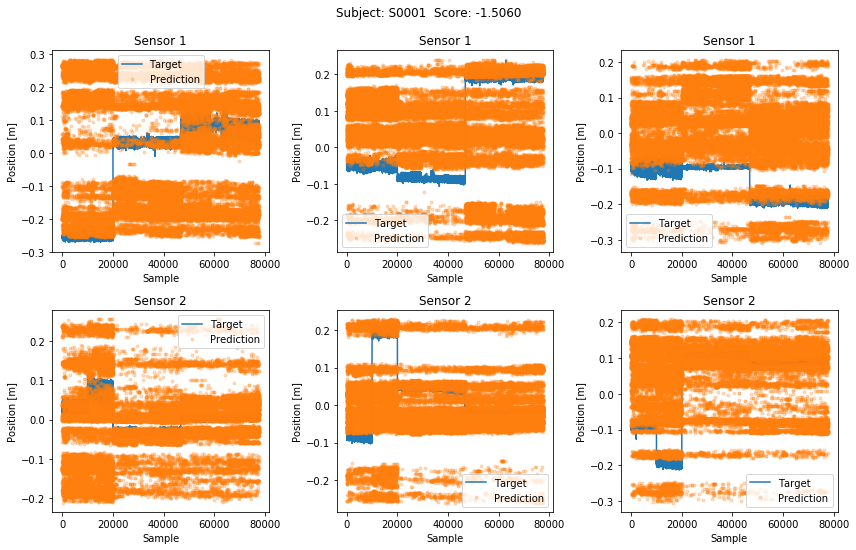

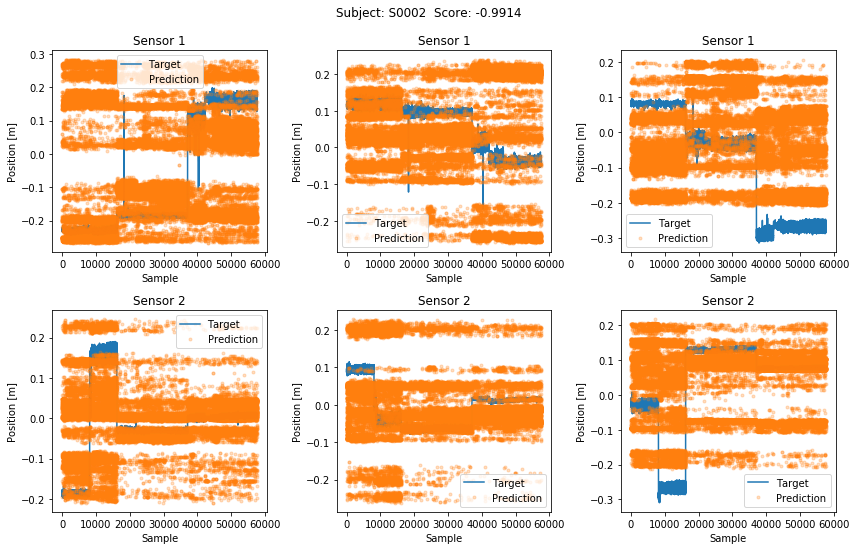

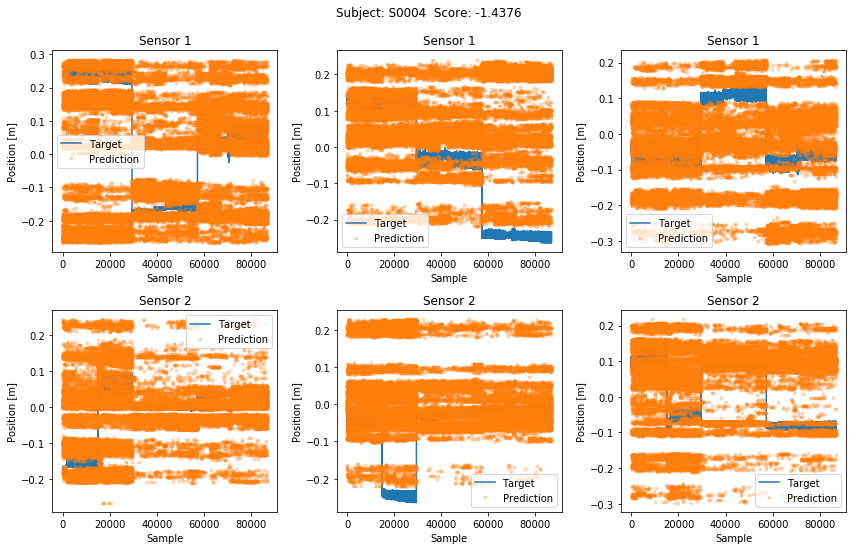

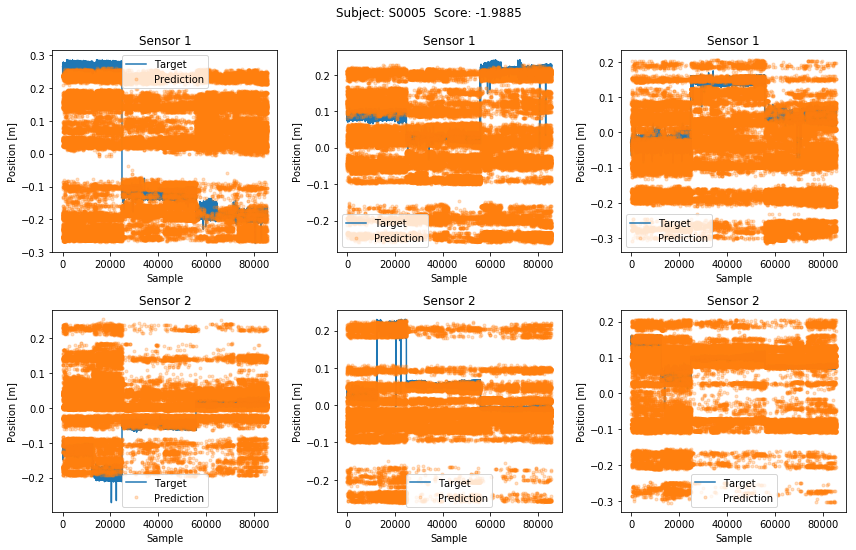

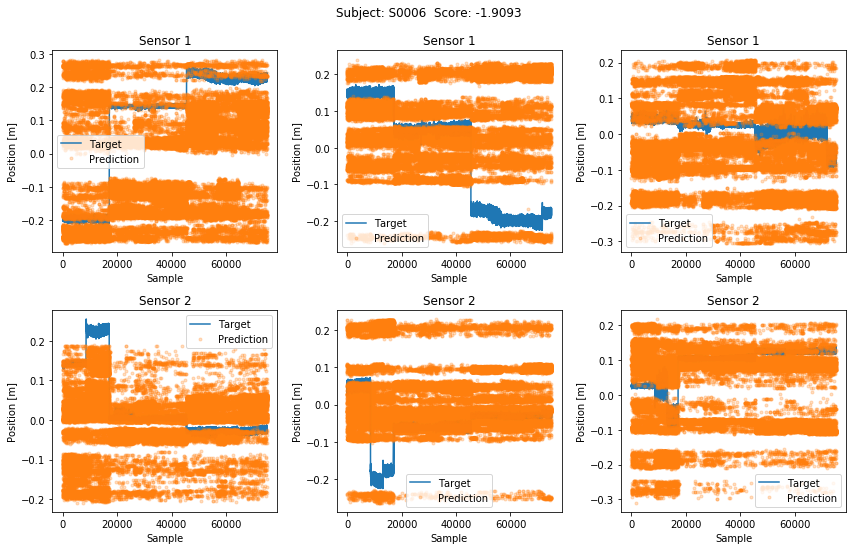

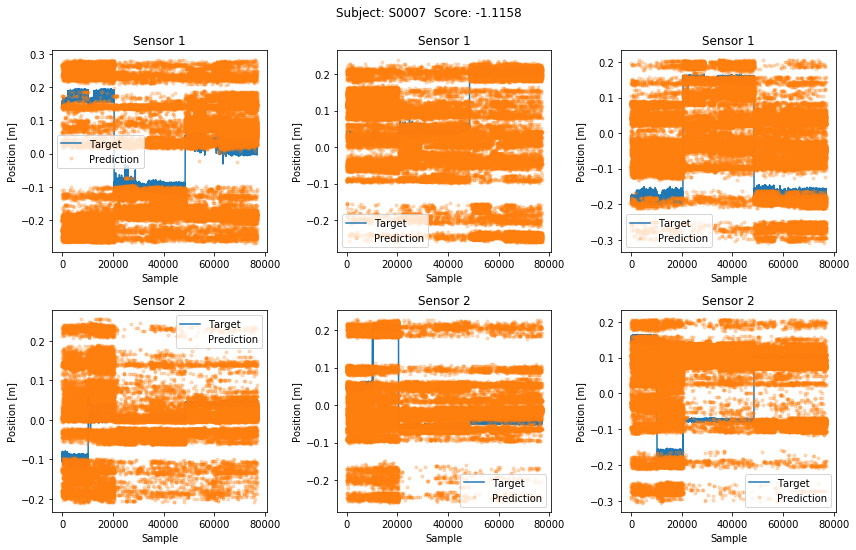

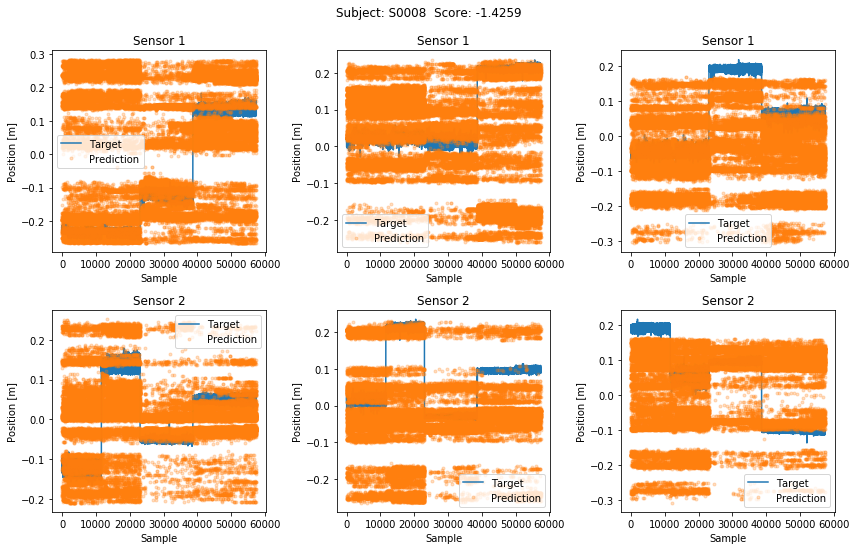

In [8]:
sc, r2, figs = run_ml(dnw, tnw, subjs, model, plot='6')

In [90]:
# 0-1, 1-2, 2-4, 3-5, 4-6, 5-7, 6-8
figs[1].savefig('/home/lukas/Dropbox/Masters/Class - Machine Learning/Project/Images/Decision Tree Images/LR_magnitude_npf_w40_S0002.png', bbox_to_inches='tight', transparent=True)

In [11]:
# Windowing scores
win_score = dict()
win_r2 = dict()
windows = [5, 10, 15, 20, 25, 30, 35, 40]

for win in windows:
    dw, tw, subjs_w, _, _ = window_ml_data(dnw, tnw, win, subjs, 'None', 'None')
    model = LinearRegression()
    win_score[win], win_r2[win], figs = run_ml(dw, tw, subjs_w, model, plot=None, verbose=False)

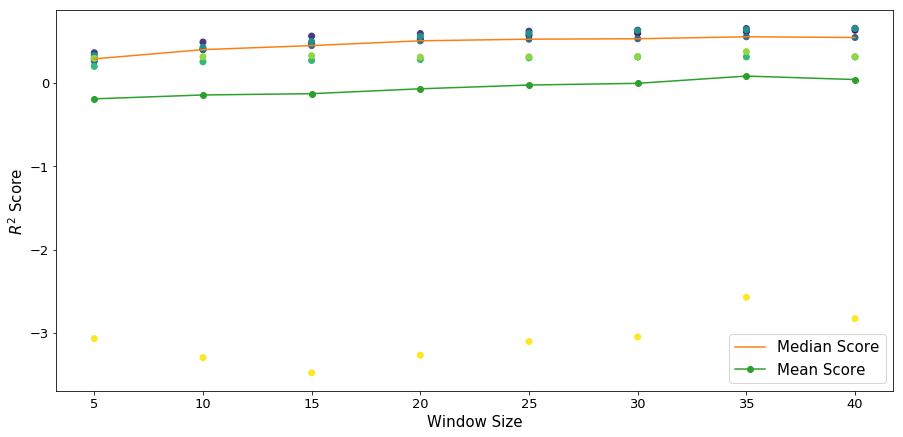

In [15]:
scores = np.array([win_r2[key] for key in win_score.keys()])
rwins = np.repeat(windows, 7).reshape((8, 7))
c = np.tile(np.arange(7), 8).reshape((8, 7))

fwin, axwin = pl.subplots(figsize=(15, 7))
axwin.tick_params(axis='both', labelsize=13)
axwin.scatter(rwins, scores, c=c)
axwin.plot(windows, np.median(scores, axis=1), color='C1', label='Median Score')
axwin.plot(windows, np.mean(scores, axis=1), 'o-', color='C2', label='Mean Score')
axwin.legend(loc='best', fontsize=15)
axwin.set_xlabel('Window Size', fontsize=15)
axwin.set_ylabel(r'$R^2$ Score', fontsize=15)
# fwin.savefig('/home/lukas/Dropbox/Masters/Class - Machine Learning/Project/window_scores', bbox_to_inches='tight', transparent=True)

In [16]:
# stored LR results
lrres = dict()
lrres['jcc_npf_nw'] = [-1.4664, -.1108, -.3730, -1.13117, -1.1147, -.22, -.4901]
lrres['jcc_npf_w10'] = [-1.5652, -.1323, -.4526, -1.473, -1.4539, -.356, -.592]
lrres['jcc_2pf_nw'] = [-1.7154, -.1424, -.8262, -1.6219, -1.8293, -.4116, -1.2441]
lrres['jcc_2pf_w10'] = [-2.3298, -1.0689, -1.8255, -2.9345, -3.1398, -2.4979, -2.9863]

lrres['jcs_npf_nw'] = [-3.1122, -0.0979, -0.9809, -1.0545, -1.1611, -0.1524, -1.2435]
lrres['jcs_npf_w10'] = [-3.5975, 0.0349, -0.9511, -1.1651, -1.4965, -0.1373, -1.7536]
lrres['jcs_2pf_nw'] = [-3.4717, -0.0819, -2.0845, -1.3112, -1.6684, -0.5311, -3.3060]
lrres['jcs_2pf_w10'] = [-4.2888, -0.1016, -3.4568, -2.2281, -2.9060, -4.6063, -5.4165]

lrres['jm_npf_nw'] = [0.1110, 0.1738, 0.1019, 0.2186, 0.1291, 0.2051  , -2.3889]
lrres['jm_2pf_nw'] = [0.2672, 0.2465, 0.0476, 0.3304, 0.2719  , -0.4037  , -7.1309]
lrres['jm_npf_w10'] = [0.3982, 0.5496, 0.3544, 0.4429, 0.2754, 0.3698  , -3.4696]
lrres['jm_2pf_w10'] = [0.5220, 0.4397, -0.0379, 0.4436, 0.4018  , -5.9282  , -10.6486]

In [18]:
for key in lrres.keys():
    print(f'{key}  {np.mean(lrres[key]):.4f}   {np.median(lrres[key]):.4f}')

jcc_npf_nw  -0.7009   -0.4901
jcc_npf_w10  -0.8607   -0.5920
jcc_2pf_nw  -1.1130   -1.2441
jcc_2pf_w10  -2.3975   -2.4979
jcs_npf_nw  -1.1146   -1.0545
jcs_npf_w10  -1.2952   -1.1651
jcs_2pf_nw  -1.7793   -1.6684
jcs_2pf_w10  -3.2863   -3.4568
jm_npf_nw  -0.2071   0.1291
jm_2pf_nw  -0.9101   0.2465
jm_npf_w10  -0.1542   0.3698
jm_2pf_w10  -2.1154   0.4018


In [21]:
# stored NN results
nn_sc, nn_r2 = pickle.load(open('nn_layers.pickle', 'rb'))

In [23]:
for key in nn_r2:
    print(f'{key}{np.mean(nn_r2[key]):8.4f}{np.median(nn_r2[key]):8.4f}')

100t-50t-2  0.3613  0.6578
180t-90t-2  0.4385  0.6403
180t-4t-90t-2  0.3672  0.6675
180t-4t-18t-2  0.3328  0.6667
180t-2t-90t-2  0.3018  0.6717
180t-8t-90t-2  0.3460  0.7010
180t-8t-90t-4t-45t-2  0.4132  0.6419
180r-8t-90t-2  0.3070  0.6577
